Performing Grid Search for Random Forest...
Fitting 5 folds for each of 432 candidates, totalling 2160 fits

Best parameters for Random Forest: {'rf__class_weight': 'balanced', 'rf__max_depth': 20, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 5, 'rf__n_estimators': 300}
Best cross-validation score for Random Forest: 0.40749690340730166

Plotting learning curve...


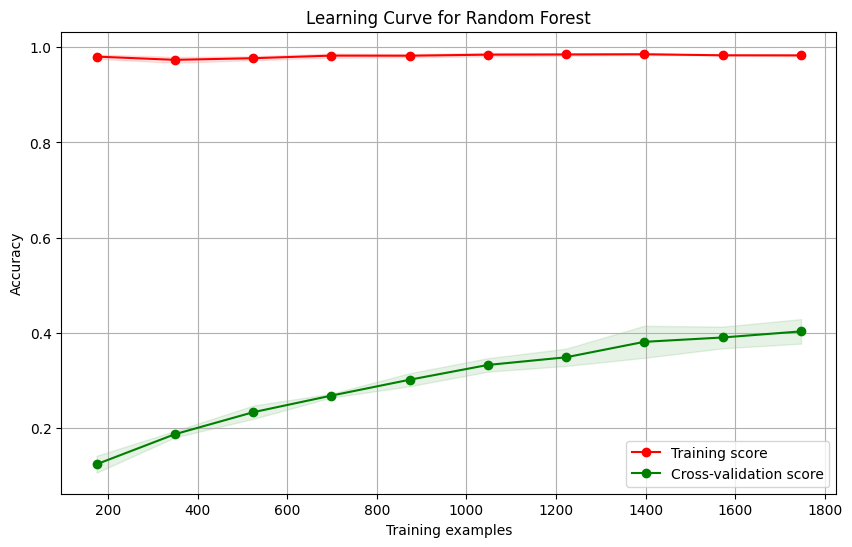


Test Set Results:
Accuracy: 0.4176
Log-loss: 2.9231
F1-score: 0.3892

Classification Report:
               precision    recall  f1-score   support

     Abundant       0.00      0.00      0.00         3
       Active       0.00      0.00      0.00         3
        Adult       0.50      0.67      0.57         3
        Agile       0.50      1.00      0.67         3
     Alluring       0.33      0.33      0.33         3
      Amiable       0.50      0.33      0.40         3
      Amusing       0.25      0.33      0.29         3
      Aqueous       0.00      0.00      0.00         3
 Aristocratic       0.50      0.67      0.57         3
     Aromatic       0.40      0.67      0.50         3
     Artistic       0.67      0.67      0.67         3
Authoritative       0.50      0.33      0.40         3
       Bitter       0.50      0.33      0.40         3
      Bitterl       0.60      1.00      0.75         3
         Bold       0.00      0.00      0.00         3
       Bright       0.50 

c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Model Performance:
Training set score: 0.9785
Test set score: 0.4176
Out-of-bag score: 0.3924
The model might still be overfitting, but less severely than before.

Feature ranking:
1. RGB3_R (0.114245)
2. RGB3_G (0.114086)
3. RGB2_R (0.113522)
4. RGB2_B (0.113258)
5. RGB1_B (0.112340)
6. RGB1_R (0.112208)
7. RGB3_B (0.108184)
8. RGB1_G (0.106292)
9. RGB2_G (0.105866)


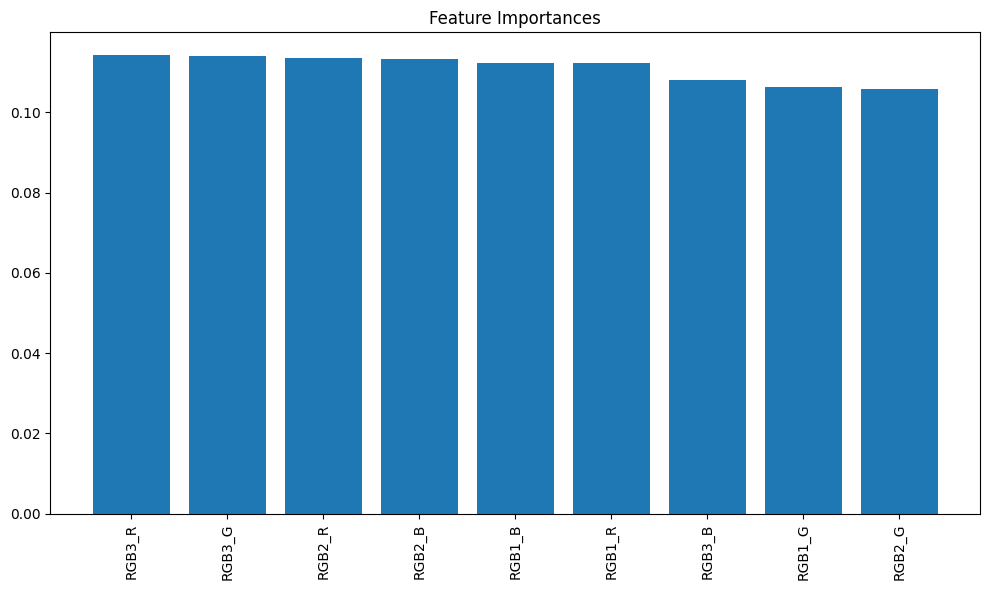

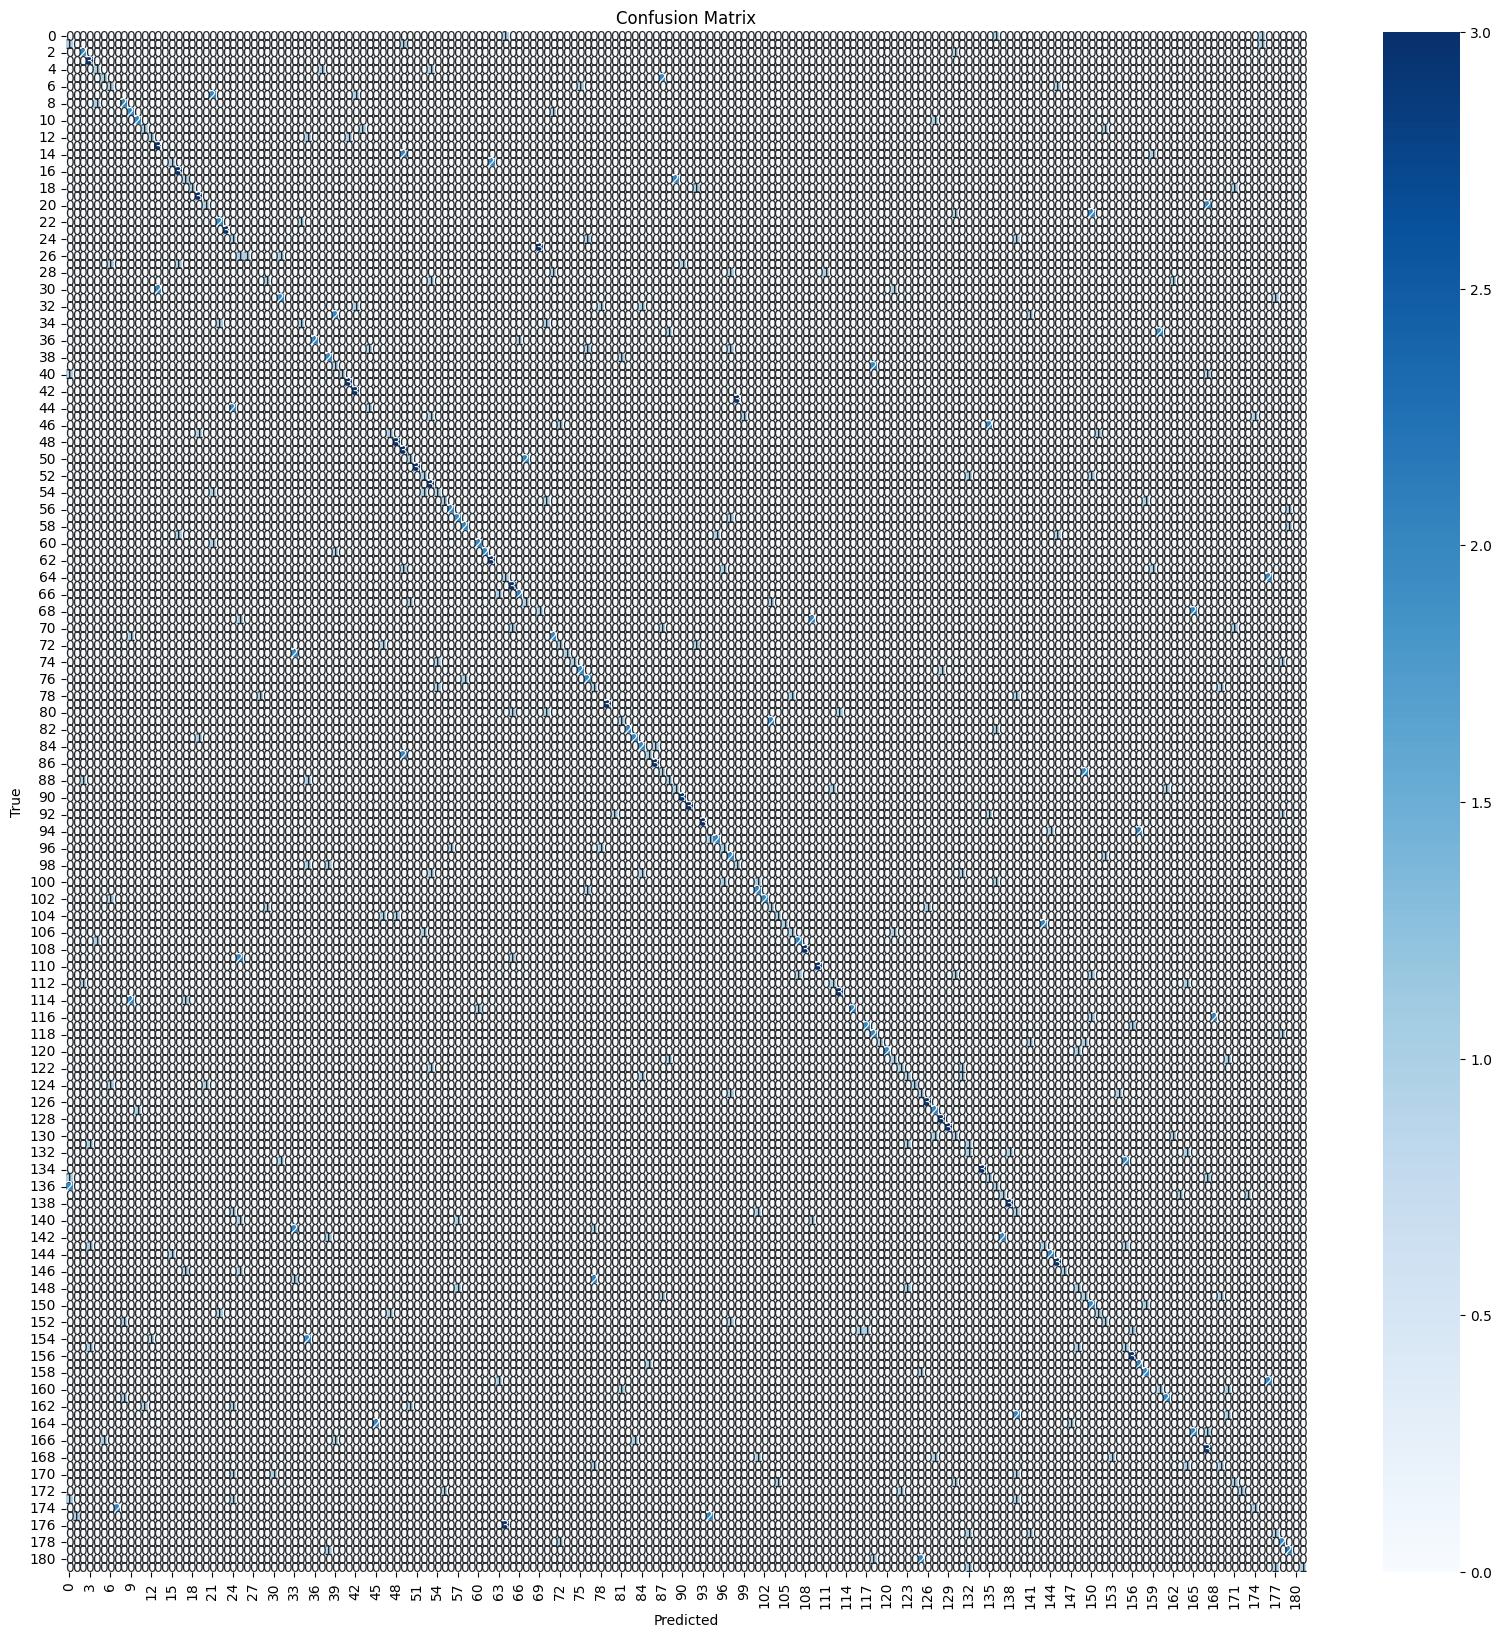

In [1]:
# Import necessary libraries
import numpy as np  # For numerical operations
import pandas as pd  # For data manipulation and analysis
import matplotlib.pyplot as plt  # For plotting
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve, StratifiedKFold  # For model selection and evaluation
from sklearn.ensemble import RandomForestClassifier  # The Random Forest algorithm
from sklearn.preprocessing import StandardScaler  # For feature scaling
from sklearn.pipeline import Pipeline  # For creating a preprocessing and modeling pipeline
from sklearn.metrics import accuracy_score, log_loss, f1_score, classification_report  # For model evaluation
import seaborn as sns  # For enhanced visualizations
from sklearn.feature_selection import SelectFromModel


# Load the dataset
data = pd.read_csv('resampled_dataset.csv')
X = data.iloc[:, :-1].values / 255.0  # Extract features (RGB values) and normalize to [0, 1]
y = data.iloc[:, -1].values  # Extract target variable (emotion labels)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
# 80% for training, 20% for testing, use random_state for reproducibility, stratify to maintain class distribution

# Define a function to perform grid search for hyperparameter tuning and StatifiedKFold for cross-validation
def perform_grid_search(model, param_grid, X, y):
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  # 5-fold cross-validation each time is using a different part as the validation set
    # shuffle in order not to affect the distribution of the data the resutls
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv, n_jobs=-1, scoring='accuracy', verbose=2)
    grid_search.fit(X, y)
    return grid_search

# Define a function to plot the learning curve
# Creates a plot showing how the model's performance changes as it sees more training data
def plot_learning_curve(model, X, y, title):
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10), scoring='accuracy'
    )
    
    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Accuracy")
    plt.grid()
    
    # Plot mean and standard deviation of training scores
    plt.fill_between(train_sizes, np.mean(train_scores, axis=1) - np.std(train_scores, axis=1),
                     np.mean(train_scores, axis=1) + np.std(train_scores, axis=1), alpha=0.1, color="r")
    # Plot mean and standard deviation of test scores
    plt.fill_between(train_sizes, np.mean(test_scores, axis=1) - np.std(test_scores, axis=1),
                     np.mean(test_scores, axis=1) + np.std(test_scores, axis=1), alpha=0.1, color="g")
    plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', color="r", label="Training score")
    plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', color="g", label="Cross-validation score")
    
    plt.legend(loc="best")
    plt.show()

# Define parameter grid for Random Forest
rf_param_grid = {
    'rf__n_estimators': [100, 200, 300, 400, 500],  # Number of trees in the forest
    'rf__max_depth': [5, 10, 15, 20],  # Maximum depth of the trees , because deep depth can lead to overfitting
    'rf__min_samples_split': [2, 5, 10, 15, 20],  # Minimum number of samples required to split an internal node 
    'rf__min_samples_leaf': [1, 2, 4, 6, 8],  # Minimum number of samples required to be at a leaf node
    'rf__max_features': ['sqrt', 'log2', None],  # Number of features to consider when looking for the best split
    'rf__bootstrap': [True],
    'rf__class_weight': ['balanced', 'balanced_subsample', None]  # Weights associated with classes
}

# Create Random Forest model with preprocessing pipeline
rf = Pipeline([
    # ('scaler', StandardScaler()),  # Standardize features - not necessary for Random Forest because each feature (R, G, B values) is already on the same scale and range.
    ('feature_selection', SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=42))),
    ('rf', RandomForestClassifier(random_state=42, oob_score=True))  # Random Forest classifier
])

# Perform grid search
print("Performing Grid Search for Random Forest...")
rf_grid_search = perform_grid_search(rf, rf_param_grid, X_train, y_train)

# Print best parameters and scores
print("\nBest parameters for Random Forest:", rf_grid_search.best_params_)
print("Best cross-validation score for Random Forest:", rf_grid_search.best_score_)

# Plot learning curve
print("\nPlotting learning curve...")
plot_learning_curve(rf_grid_search.best_estimator_, X_train, y_train, "Learning Curve for Random Forest")

# Gets the best model from grid search and makes predictions on the test set and with this way we evaluate the model's performance on unseen data
best_rf = rf_grid_search.best_estimator_
y_pred = best_rf.predict(X_test)  # Make predictions on test set
y_pred_proba = best_rf.predict_proba(X_test)  # Get prediction probabilities

# Calculate and print model evaluation metrics
print("\nTest Set Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")  # Overall accuracy
print(f"Log-loss: {log_loss(y_test, y_pred_proba):.4f}")  # Logarithmic loss
print(f"F1-score: {f1_score(y_test, y_pred, average='weighted'):.4f}")  # F1 score (harmonic mean of precision and recall)

# Print detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Check for overfitting/underfitting
train_score = best_rf.score(X_train, y_train)  # Score on training set
test_score = best_rf.score(X_test, y_test)  # Score on test set
print("\nModel Performance:")
print(f"Training set score: {train_score:.4f}")
print(f"Test set score: {test_score:.4f}")
print(f"Out-of-bag score: {best_rf.named_steps['rf'].oob_score_:.4f}")  # Out-of-bag score (internal cross-validation)

# Compare training and test scores to assess overfitting/underfitting
if train_score - test_score > 0.05:
    print("The model might still be overfitting, but less severely than before.")
elif test_score - train_score > 0.05:
    print("The model might be underfitting.")
else:
    print("The model seems to be well-balanced.")

#-------------------------------------
# Feature importance analysis
feature_importance = best_rf.named_steps['rf'].feature_importances_  # Get feature importances
feature_names = data.columns[:-1]  # Get feature names (exclude the target column)

# Sort feature importances in descending order
indices = np.argsort(feature_importance)[::-1]

# Print the feature ranking
print("\nFeature ranking:")
for f in range(X.shape[1]):
    print("%d. %s (%f)" % (f + 1, feature_names[indices[f]], feature_importance[indices[f]]))

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), feature_importance[indices])
plt.xticks(range(X.shape[1]), [feature_names[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()
# -------------------------------------

# Confusion Matrix - I can see where the model is making mistakes 
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)  # Compute confusion matrix
plt.figure(figsize=(20, 20))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')  # Plot confusion matrix as a heatmap
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Important info about some parts of the code :

- grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv, n_jobs=-1, scoring='accuracy', verbose=2)
    
    - estimator=model: This is the model you're optimizing (in this case, the Random Forest classifier).
    - param_grid=param_grid: This is the grid of parameters to search over.
    - cv=cv: This specifies the cross-validation strategy (the StratifiedKFold we just created).
    - n_jobs=-1: This tells the process to use all available CPU cores, speeding up the search.
    - scoring='accuracy': This specifies that we want to use accuracy as our evaluation metric.
    - verbose=2: This sets the verbosity level, controlling the amount of output during the process.

- rf = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier(random_state=42, oob_score=True))
])

   - Δημιουργώ έναν αγωνγό επεξεργασίας και εκαπαίδευσης του Random Forest όπου τα δεδομένα περνούν διαδοχικά από διάφορα βήματα επεξεργασίας και εκπαίδευσης . Το πλεονέκτημα της χρήσης ενός Pipeline είναι ότι διασφαλίζει ότι οι ίδιοι μετασχηματισμοί (στην προκειμένη περίπτωση, η κλιμάκωση) εφαρμόζονται με συνέπεια τόσο στα δεδομένα εκπαίδευσης όσο και στα δεδομένα δοκιμής. 
   
   Επιτρέπει επίσης την προεπεξεργασία και το μοντέλο ως έναν ενιαίο εκτιμητή, κάτι που είναι ιδιαίτερα χρήσιμο στη διασταυρούμενη επικύρωση και την αναζήτηση πλέγματος. Ο RandomForestClassifier αρχικοποιείται με random_state=42 για λόγους αναπαραγωγιμότητας και oob_score=True για τον υπολογισμό του out-of-bag score, το οποίο είναι ένας τρόπος για να λάβετε μια αμερόληπτη εκτίμηση της απόδοσης του μοντέλου χωρίς να χρειάζεστε ένα ξεχωριστό σύνολο επικύρωσης.

- Output : for this line : " print(classification_report(y_test , y_pred) " 
    Δείχνει τις κύριες μετρικές ταξινόμησης για κάθε κλάση - συναίσθημα 


 

### Testing another approach!

Performing Randomized Search for Random Forest...
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


c:\Python312\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,



Best parameters for Random Forest: {'n_estimators': 400, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_samples': 0.9, 'max_features': 'log2', 'max_depth': 20, 'class_weight': 'balanced', 'bootstrap': True}
Best cross-validation score for Random Forest: 0.43992007992007987

Test Set Results:
Balanced Accuracy: 0.4537
Accuracy: 0.4520
Log-loss: 2.7152
F1-score: 0.4393

Classification Report:
Abundant:
  Precision: 0.50
  Recall: 0.46
  F1-score: 0.48
  Support: 13

Active:
  Precision: 0.50
  Recall: 0.29
  F1-score: 0.36
  Support: 14

Adult:
  Precision: 0.67
  Recall: 0.31
  F1-score: 0.42
  Support: 13

Agile:
  Precision: 0.10
  Recall: 0.07
  F1-score: 0.08
  Support: 14

Alluring:
  Precision: 0.40
  Recall: 0.31
  F1-score: 0.35
  Support: 13

Amiable:
  Precision: 0.35
  Recall: 0.43
  F1-score: 0.39
  Support: 14

Amusing:
  Precision: 0.50
  Recall: 0.38
  F1-score: 0.43
  Support: 13

Aqueous:
  Precision: 0.47
  Recall: 0.54
  F1-score: 0.50
  Support: 13

Aristocrati

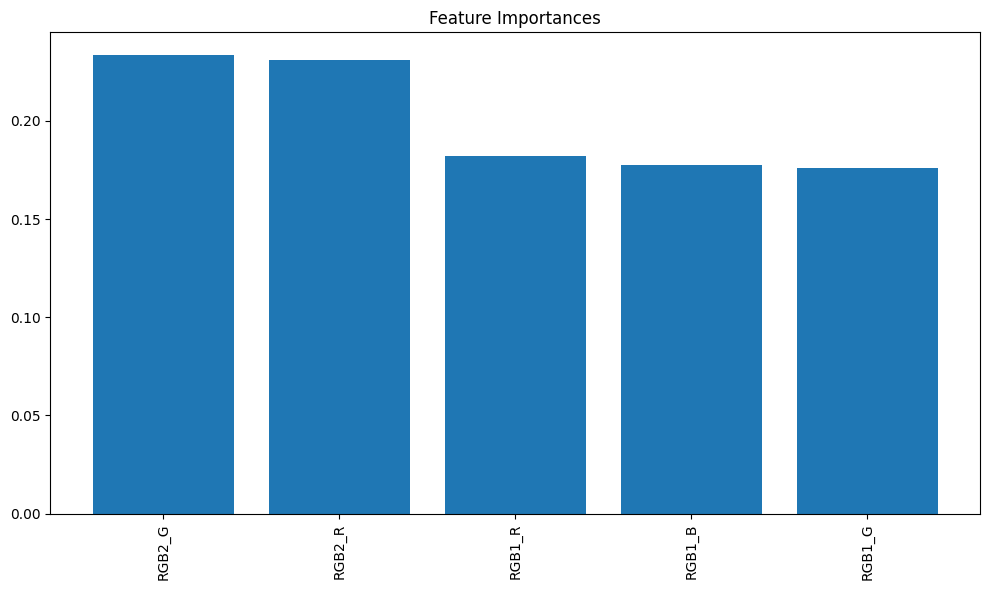

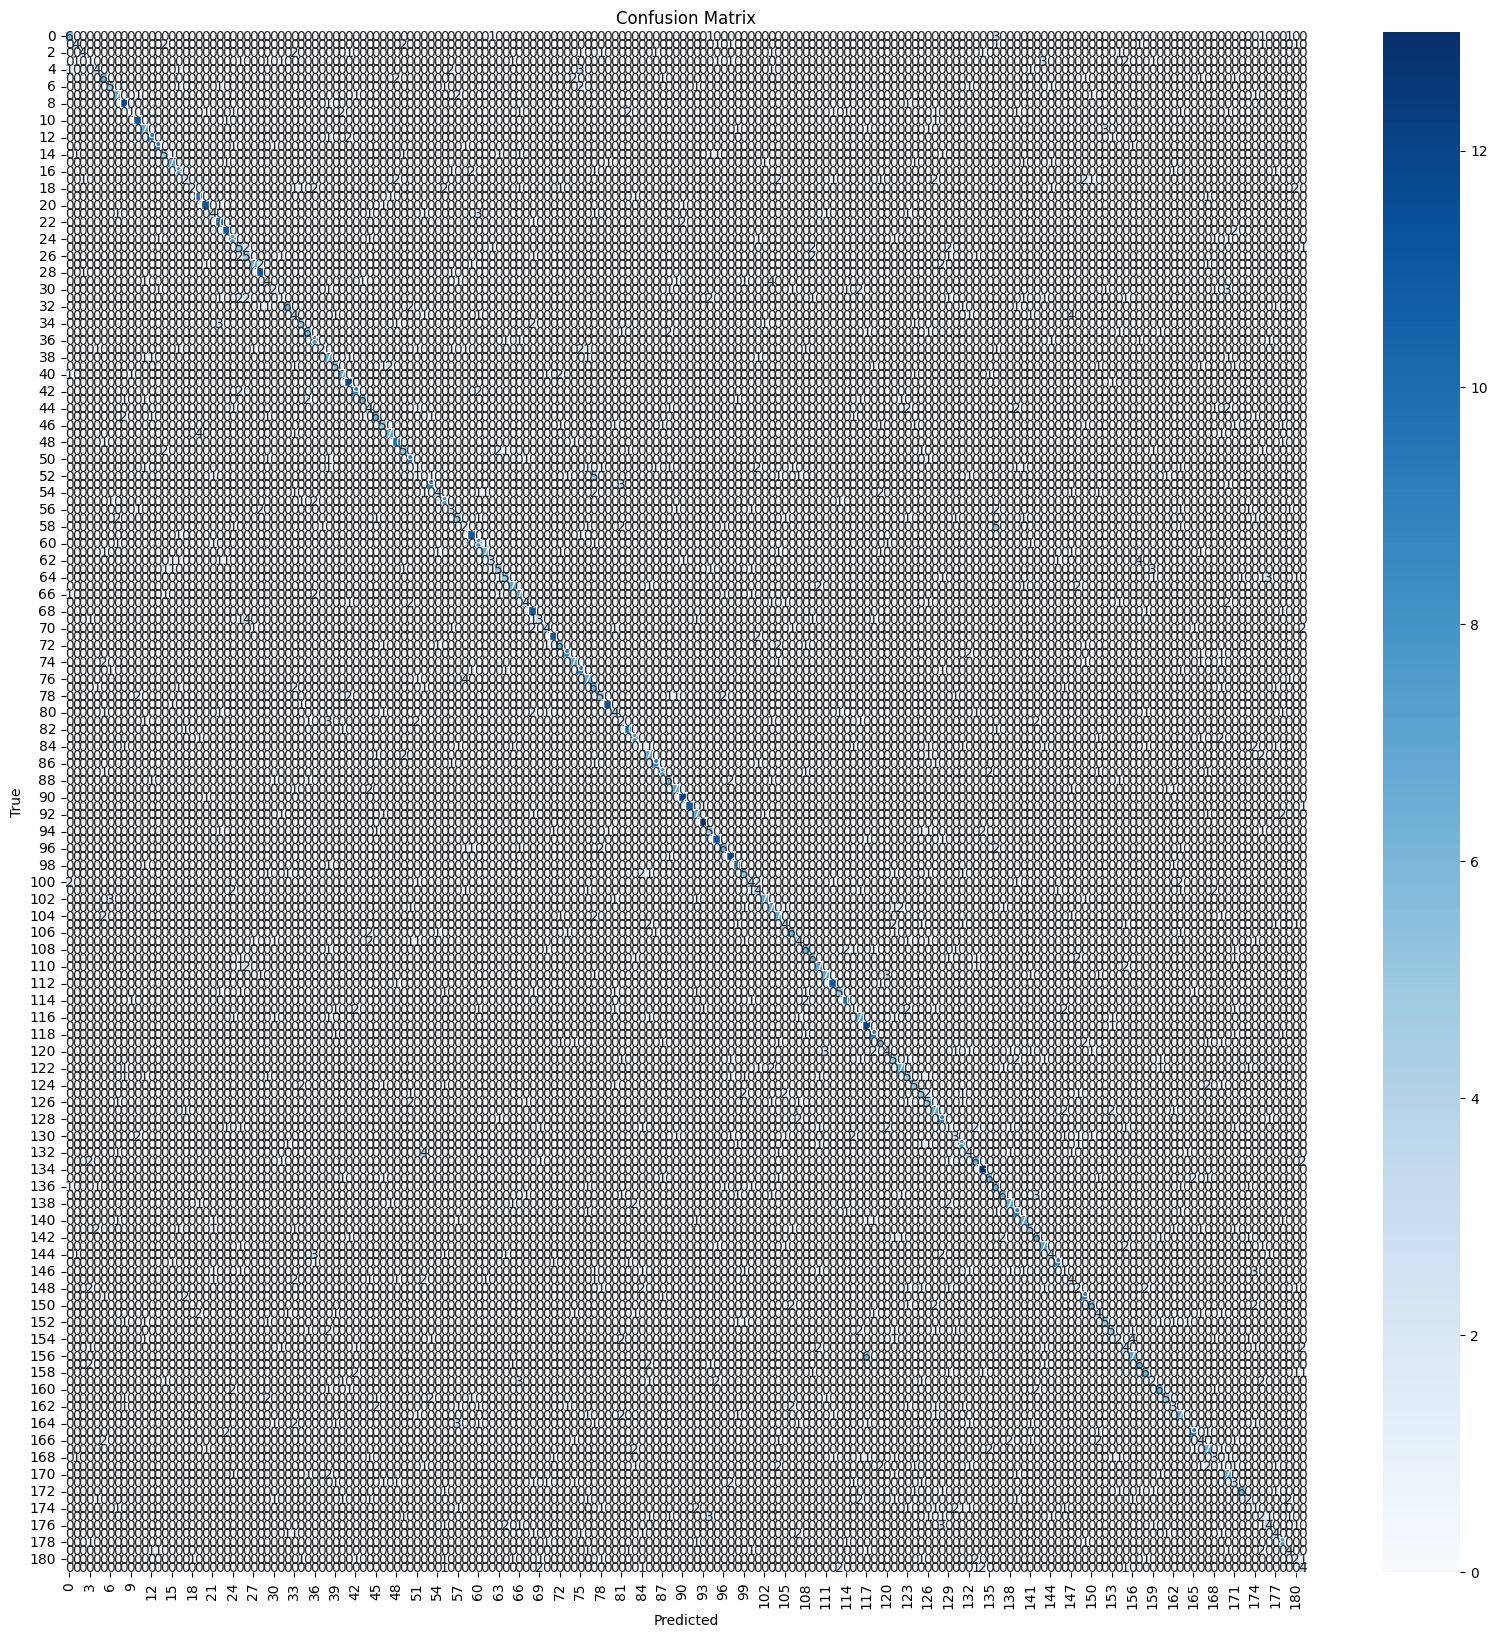

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, log_loss, f1_score, classification_report, balanced_accuracy_score
from sklearn.feature_selection import SelectFromModel
import seaborn as sns

# Load the dataset
data = pd.read_csv('final_dataset.csv')
X = data.iloc[:, :-1].values / 255.0  # Extract features (RGB values) and normalize to [0, 1]
y = data.iloc[:, -1].values  # Extract target variable (emotion labels)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
# 80% for training, 20% for testing, use random_state for reproducibility, stratify to maintain class distribution

# Define a function for Random Forest with early stopping
def rf_with_early_stopping(X, y, max_n_estimators, step=10):
    # Initialize cross-validation strategy
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # Initialize Random Forest with warm start for incremental fitting
    rf = RandomForestClassifier(warm_start=True, n_estimators=step, random_state=42)
    
    scores = []
    # Incrementally increase the number of estimators
    for n_estimators in range(step, max_n_estimators + 1, step):
        rf.set_params(n_estimators=n_estimators)
        rf.fit(X, y)
        # Compute cross-validation score
        score = cross_val_score(rf, X, y, cv=cv, scoring='balanced_accuracy').mean()
        scores.append(score)
        
        # Check for early stopping condition
        if len(scores) > 5 and scores[-1] < np.mean(scores[-6:-1]):
            break
    
    # Return the model with the best number of estimators
    return rf.set_params(n_estimators=scores.index(max(scores)) * step + step)

# Perform feature selection
selector = SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=42), threshold='median')
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

# Define parameter grid for Random Forest
rf_param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [5, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 4, 6, 8],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True],  
    'class_weight': ['balanced', 'balanced_subsample', None],
    'max_samples': [0.5, 0.7, 0.9, None]
}

# Create Random Forest model
rf = RandomForestClassifier(random_state=42)

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=rf_param_grid,
    n_iter=200,  # Increase from 100
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    verbose=2,
    random_state=42,
    n_jobs=-1,
    scoring='balanced_accuracy'
)

# Perform randomized search
print("Performing Randomized Search for Random Forest...")
random_search.fit(X_train_selected, y_train)

# Print best parameters and scores
print("\nBest parameters for Random Forest:", random_search.best_params_)
print("Best cross-validation score for Random Forest:", random_search.best_score_)

# Get the best model
best_rf = random_search.best_estimator_

# Evaluate on the test set
y_pred = best_rf.predict(X_test_selected)
y_pred_proba = best_rf.predict_proba(X_test_selected)

print("\nTest Set Results:")
print(f"Balanced Accuracy: {balanced_accuracy_score(y_test, y_pred):.4f}")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Log-loss: {log_loss(y_test, y_pred_proba):.4f}")
print(f"F1-score: {f1_score(y_test, y_pred, average='weighted'):.4f}")

# Print detailed classification report
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred, zero_division=0)

print("\nClassification Report:")
for i, label in enumerate(np.unique(y)):
    print(f"{label}:")
    print(f"  Precision: {precision[i]:.2f}")
    print(f"  Recall: {recall[i]:.2f}")
    print(f"  F1-score: {f1[i]:.2f}")
    print(f"  Support: {support[i]}")
    print()

# Check for overfitting/underfitting
train_score = best_rf.score(X_train_selected, y_train)
test_score = best_rf.score(X_test_selected, y_test)

print("\nModel Performance:")
print(f"Training set score: {train_score:.4f}")
print(f"Test set score: {test_score:.4f}")

if train_score - test_score > 0.05:
    print("The model might still be overfitting, but less severely than before.")
elif test_score - train_score > 0.05:
    print("The model might be underfitting.")
else:
    print("The model seems to be well-balanced.")

# Feature importance analysis
feature_importance = best_rf.feature_importances_
feature_names = data.columns[:-1]  # Get feature names (exclude the target column)

# Sort feature importances in descending order
indices = np.argsort(feature_importance)[::-1]

# Print the feature ranking
print("\nFeature ranking:")
for f in range(X_train_selected.shape[1]):
    print("%d. %s (%f)" % (f + 1, feature_names[indices[f]], feature_importance[indices[f]]))

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(X_train_selected.shape[1]), feature_importance[indices])
plt.xticks(range(X_train_selected.shape[1]), [feature_names[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()

def plot_learning_curve(estimator, X, y, title):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10), scoring='balanced_accuracy'
    )
    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.grid()
    plt.fill_between(train_sizes, np.mean(train_scores, axis=1) - np.std(train_scores, axis=1),
                     np.mean(train_scores, axis=1) + np.std(train_scores, axis=1), alpha=0.1, color="r")
    plt.fill_between(train_sizes, np.mean(test_scores, axis=1) - np.std(test_scores, axis=1),
                     np.mean(test_scores, axis=1) + np.std(test_scores, axis=1), alpha=0.1, color="g")
    plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', color="r", label="Training score")
    plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', color="g", label="Cross-validation score")
    plt.legend(loc="best")
    plt.show()

# Call the function after training
plot_learning_curve(best_rf, X_train_selected, y_train, "Learning Curve for Random Forest")

# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(20, 20))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Use another cross validation , and also expanding parameter space 

Performing Randomized Search for Random Forest...
Fitting 5 folds for each of 100 candidates, totalling 500 fits

Best parameters for Random Forest: {'n_estimators': 1000, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_leaf_nodes': None, 'max_features': 'log2', 'max_depth': 35, 'class_weight': 'balanced', 'bootstrap': False}
Best cross-validation score for Random Forest: 0.4349550449550449

Test Set Results:
Balanced Accuracy: 0.4607
Accuracy: 0.4590
Log-loss: 2.4513
F1-score: 0.4489

Classification Report:
Abundant:
  Precision: 0.67
  Recall: 0.46
  F1-score: 0.55
  Support: 13

Active:
  Precision: 0.57
  Recall: 0.29
  F1-score: 0.38
  Support: 14

Adult:
  Precision: 0.44
  Recall: 0.31
  F1-score: 0.36
  Support: 13

Agile:
  Precision: 0.18
  Recall: 0.14
  F1-score: 0.16
  Support: 14

Alluring:
  Precision: 0.47
  Recall: 0.54
  F1-score: 0.50
  Support: 13

Amiable:
  Precision: 0.44
  Recall: 0.50
  F1-score: 0.47
  Support: 14

Amusing:
  Precision: 0.62
  Recall: 0.38

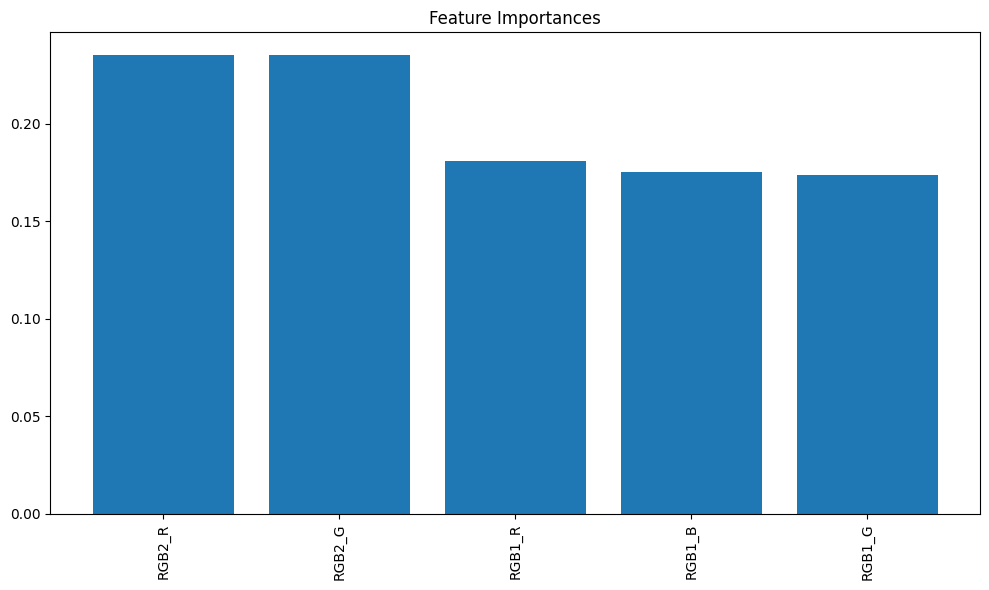

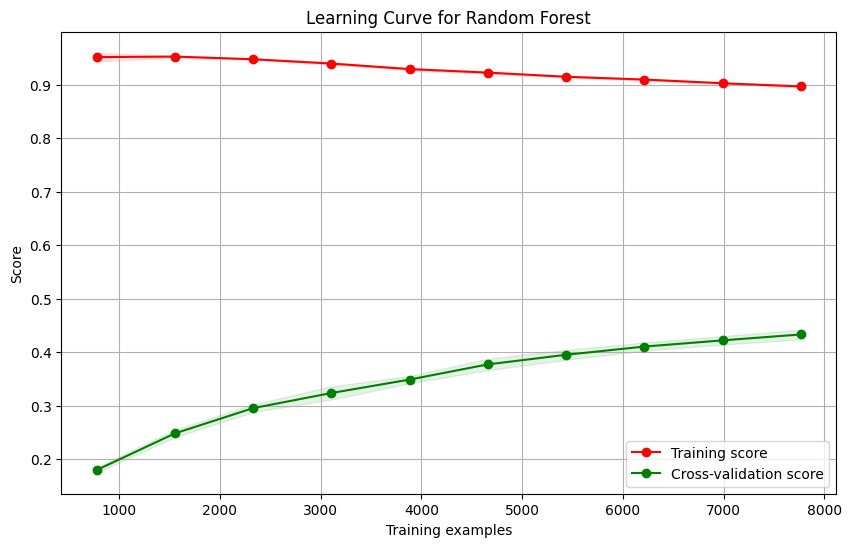

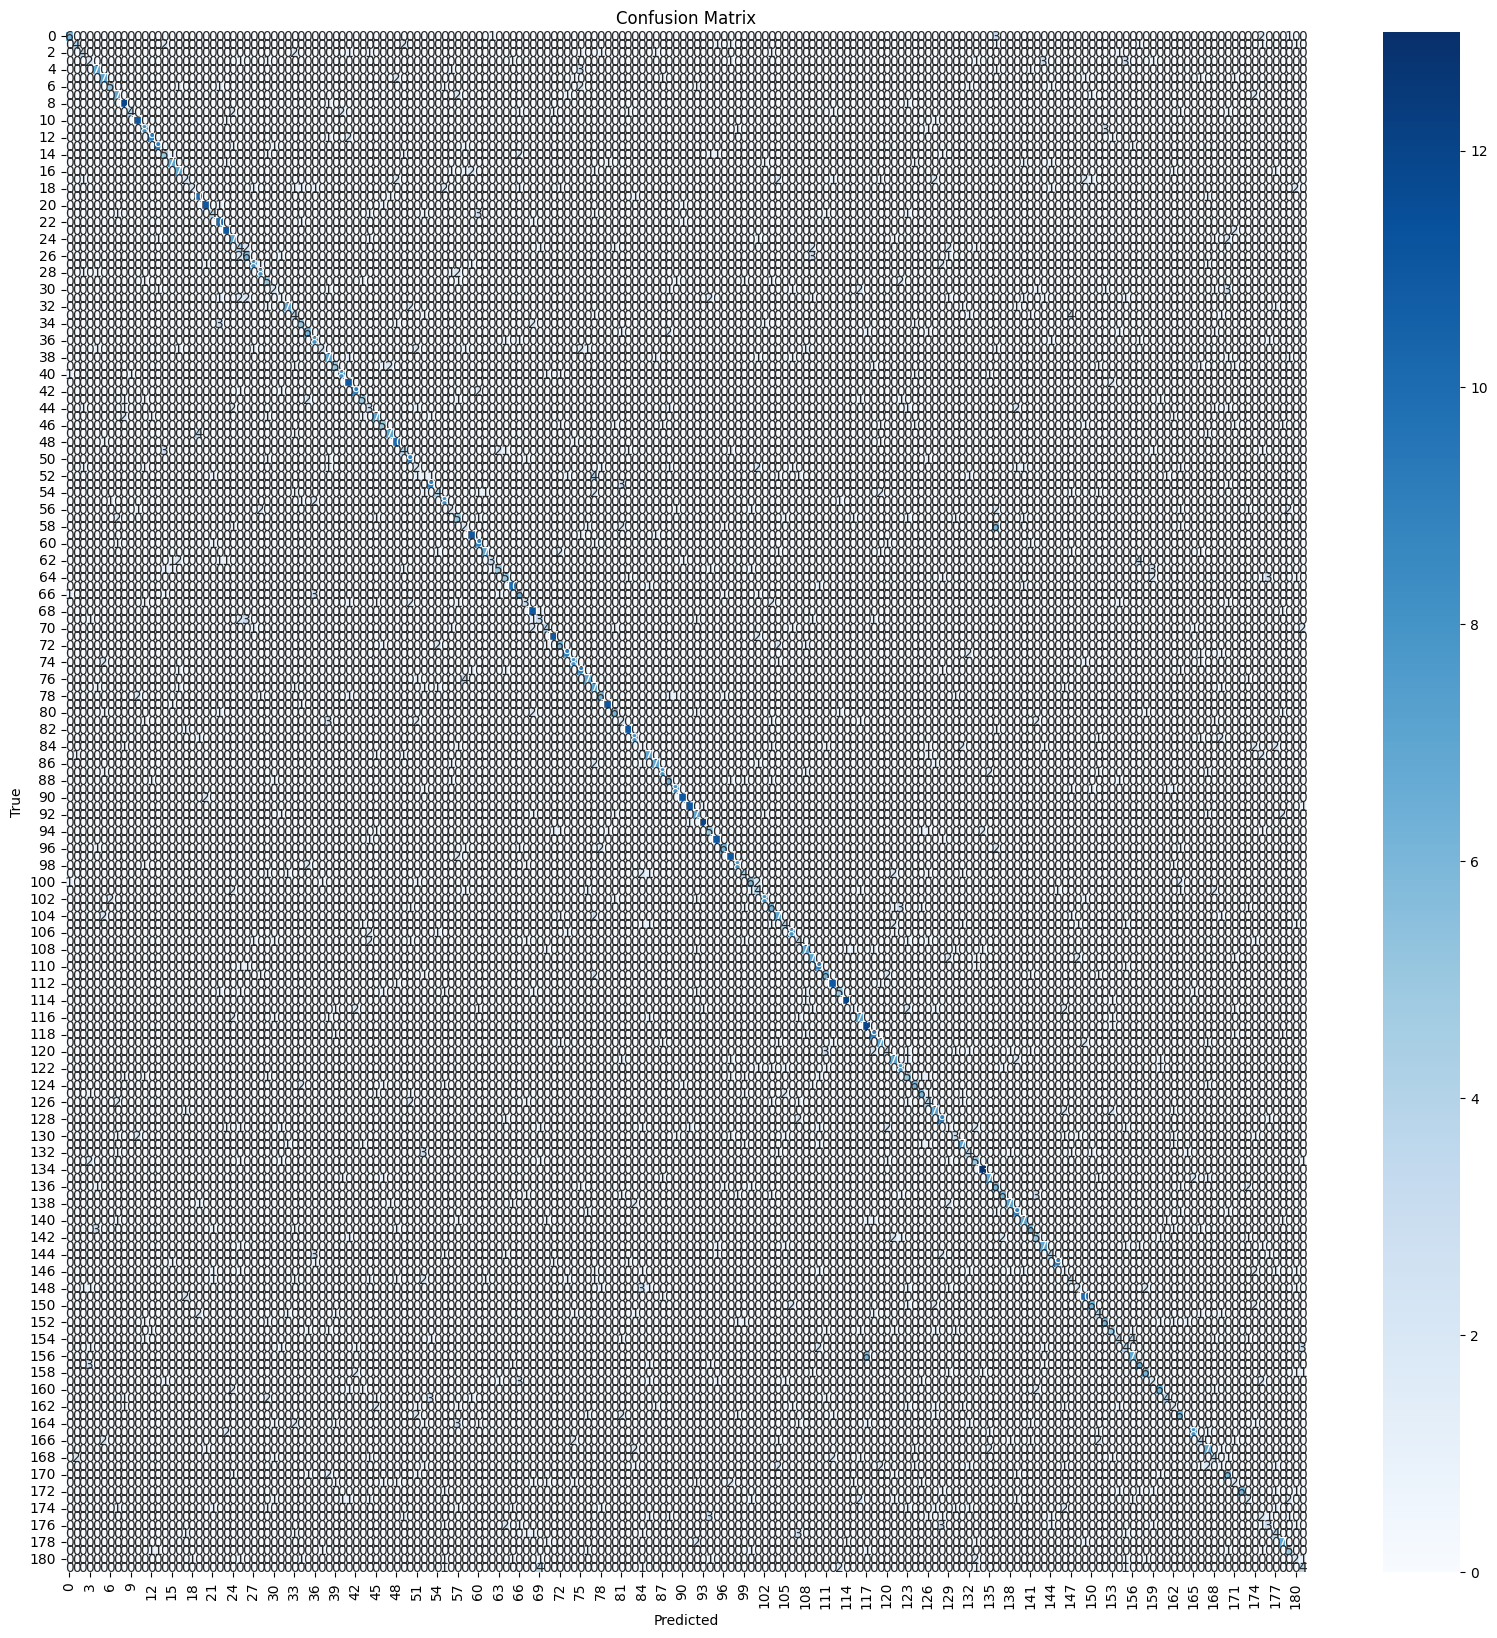

In [5]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, log_loss, f1_score, classification_report, balanced_accuracy_score
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import LabelEncoder
import seaborn as sns

# Load the dataset
data = pd.read_csv('final_dataset.csv')
X = data.iloc[:, :-1].values / 255.0  # Extract features (RGB values) and normalize to [0, 1]
y = data.iloc[:, -1].values  # Extract target variable (emotion labels)

# Encode the target labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Perform feature selection
selector = SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=42), threshold='median')
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

# Calculate class weights
class_weights = dict(zip(np.unique(y_train), 
                         len(y_train) / (len(np.unique(y_train)) * np.bincount(y_train))))

# Define expanded parameter space for RandomizedSearchCV
param_distributions = {
    'n_estimators': [int(x) for x in np.linspace(start=100, stop=1000, num=10)],
    'max_depth': [int(x) for x in np.linspace(5, 50, num=10)] + [None],
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 4, 6, 8],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False],
    'class_weight': ['balanced', 'balanced_subsample', class_weights],
    'max_leaf_nodes': [int(x) for x in np.linspace(start=10, stop=1000, num=10)] + [None]
}

# Create Random Forest model
rf = RandomForestClassifier(random_state=42)

# Set up RandomizedSearchCV with Stratified K-Fold
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_distributions,
    n_iter=100,  # Number of parameter settings that are sampled
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    verbose=2,
    random_state=42,
    n_jobs=-1,
    scoring='balanced_accuracy'
)

# Perform Randomized Search
print("Performing Randomized Search for Random Forest...")
random_search.fit(X_train_selected, y_train)

# Print best parameters and scores
print("\nBest parameters for Random Forest:", random_search.best_params_)
print("Best cross-validation score for Random Forest:", random_search.best_score_)

# Get the best model
best_rf = random_search.best_estimator_

# Evaluate on the test set
y_pred = best_rf.predict(X_test_selected)
y_pred_proba = best_rf.predict_proba(X_test_selected)

print("\nTest Set Results:")
print(f"Balanced Accuracy: {balanced_accuracy_score(y_test, y_pred):.4f}")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Log-loss: {log_loss(y_test, y_pred_proba):.4f}")
print(f"F1-score: {f1_score(y_test, y_pred, average='weighted'):.4f}")

# Print detailed classification report
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred, zero_division=0)

print("\nClassification Report:")
for i, label in enumerate(le.classes_):
    print(f"{label}:")
    print(f"  Precision: {precision[i]:.2f}")
    print(f"  Recall: {recall[i]:.2f}")
    print(f"  F1-score: {f1[i]:.2f}")
    print(f"  Support: {support[i]}")
    print()

# Check for overfitting/underfitting
train_score = best_rf.score(X_train_selected, y_train)
test_score = best_rf.score(X_test_selected, y_test)

print("\nModel Performance:")
print(f"Training set score: {train_score:.4f}")
print(f"Test set score: {test_score:.4f}")

if train_score - test_score > 0.05:
    print("The model might still be overfitting, but less severely than before.")
elif test_score - train_score > 0.05:
    print("The model might be underfitting.")
else:
    print("The model seems to be well-balanced.")

# Feature importance analysis
feature_importance = best_rf.feature_importances_
feature_names = data.columns[:-1]  # Get feature names (exclude the target column)

# Sort feature importances in descending order
indices = np.argsort(feature_importance)[::-1]

# Print the feature ranking
print("\nFeature ranking:")
for f in range(X_train_selected.shape[1]):
    print("%d. %s (%f)" % (f + 1, feature_names[indices[f]], feature_importance[indices[f]]))

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(X_train_selected.shape[1]), feature_importance[indices])
plt.xticks(range(X_train_selected.shape[1]), [feature_names[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()

# Plot learning curve
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, X, y, title):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
        n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10), scoring='balanced_accuracy'
    )
    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.grid()
    plt.fill_between(train_sizes, np.mean(train_scores, axis=1) - np.std(train_scores, axis=1),
                     np.mean(train_scores, axis=1) + np.std(train_scores, axis=1), alpha=0.1, color="r")
    plt.fill_between(train_sizes, np.mean(test_scores, axis=1) - np.std(test_scores, axis=1),
                     np.mean(test_scores, axis=1) + np.std(test_scores, axis=1), alpha=0.1, color="g")
    plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', color="r", label="Training score")
    plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', color="g", label="Cross-validation score")
    plt.legend(loc="best")
    plt.show()

# Call the function after training
plot_learning_curve(best_rf, X_train_selected, y_train, "Learning Curve for Random Forest")

# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(20, 20))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()